In [99]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = 15, 10

In [5]:
from numpy.random import choice

In [83]:
import re
import pandas as pd
import pymysql as mdb

In [2]:
from selenium import webdriver
driver_path = '/home/webdriver/chromedriver'
chromeOptions = webdriver.ChromeOptions()
prefs = {"profile.managed_default_content_settings.images":2}
chromeOptions.add_experimental_option("prefs",prefs)
browser = webdriver.Chrome(driver_path, chrome_options=chromeOptions)
login_url = 'http://forums.somethingawful.com/account.php?action=loginform&next=%2F#form'
browser.get(login_url)
username = browser.find_element_by_name("username")
password = browser.find_element_by_name("password")
username.send_keys('Grobyc')
password.send_keys('my password)
login_button = browser.find_element_by_xpath('//input[@value="Login!"]')
login_button.click()
adblock_url = 'https://chrome.google.com/webstore/detail/adblock/gighmmpiobklfepjocnamgkkbiglidom/related?hl=en-GB'
browser.get(adblock_url)

In [8]:
#reg_pat = r'since registering on <b>(.+)</b>'
name_pat = 'Profile for \'(.+)\' - The Something Awful'
reg_pat = r'Member Since</dt><dd>(.+)</dd>'
postcount_pat = r'Post Count</dt><dd>(.+)</dd>'
last_post_pat = r'Last Post</dt><dd>(.+)\s+</dd>'

pats = {'regdate':reg_pat, 'postcount':postcount_pat, 'lastpost':last_post_pat, 'name':name_pat}

first_id = 15000
last_id = 216014
sample_ids = [x+50 for x in xrange(first_id,last_id,100)]

In [187]:
banned_example = 214725
permabanned_example = 87207

In [317]:
def scrape_for_uid(uid, con=None):
    url = 'http://forums.somethingawful.com/member.php?action=getinfo&userid=%06d' % uid
    browser.get(url)
    t = browser.page_source
    if 'standarderror' not in t:
        permabanned = ('permabanned.gif' in t) or ('permabanned.png' in t)
        if permabanned:
            ban_status = 2
        else:
            banned = ('banned.gif' in t) or ('banned.png' in t)
            if banned:
                ban_status = 1
            else:
                ban_status = 0
        if con is None:
            for p in pats.keys():
                print p, re.search(pats[p],t).groups()[0]#re.findall(pats[p],t)
        else:
            values = {fieldname:re.search(pats[fieldname],t).groups()[0] for fieldname in pats.keys()}
            with con.cursor() as cur:
                sqlcmd = 'INSERT INTO Users VALUES(%d,"%s",%d,"%s","%s",%d)' % (uid, values['name'].replace('\"','\''), int(values['postcount']), values['regdate'], values['lastpost'], ban_status)
                cur.execute(sqlcmd)


In [84]:
con = mdb.connect(host='localhost',user='root',password='pwd',database='SA',charset='utf8')

In [405]:
with con:
    for uid in sample_ids:
        scrape_for_uid(uid,con)

In [85]:
query='SELECT * FROM Users'
df = pd.read_sql(query, con, parse_dates=['regdate','lastpost'])
df.sort('uid',inplace=True)
df['year'] = df.regdate.apply(lambda t:t.year)
df = df[df.year!=1969]
df = df[df.uid != 74250]
df = df[df.regdate < '2015-09-13']
df = df[df.regdate != df.regdate[2966]]
gg = df.groupby('year')

In [95]:
gg.uid.first()

year
2000     15150
2001     16600
2002     26800
2003     20100
2004     34700
2005     72500
2006     90150
2007    108300
2008    129900
2009    145500
2010    159450
2011    171350
2012    183050
2013    195000
2014    207650
2015    213200
Name: uid, dtype: int64

In [96]:
gg.uid.last()

year
2000     16450
2001     30800
2002     45450
2003     46700
2004     72450
2005     90100
2006    108250
2007    129850
2008    145450
2009    159400
2010    171300
2011    183000
2012    194950
2013    207600
2014    213150
2015    216000
Name: uid, dtype: int64

In [102]:
ser = gg.uid.last() - gg.uid.first()
ser = ser[ser > 1300]
#ser = ser.ix[:2014]
ser

year
2001    14200
2002    18650
2003    26600
2004    37750
2005    17600
2006    18100
2007    21550
2008    15550
2009    13900
2010    11850
2011    11650
2012    11900
2013    12600
2014     5500
2015     2800
Name: uid, dtype: int64

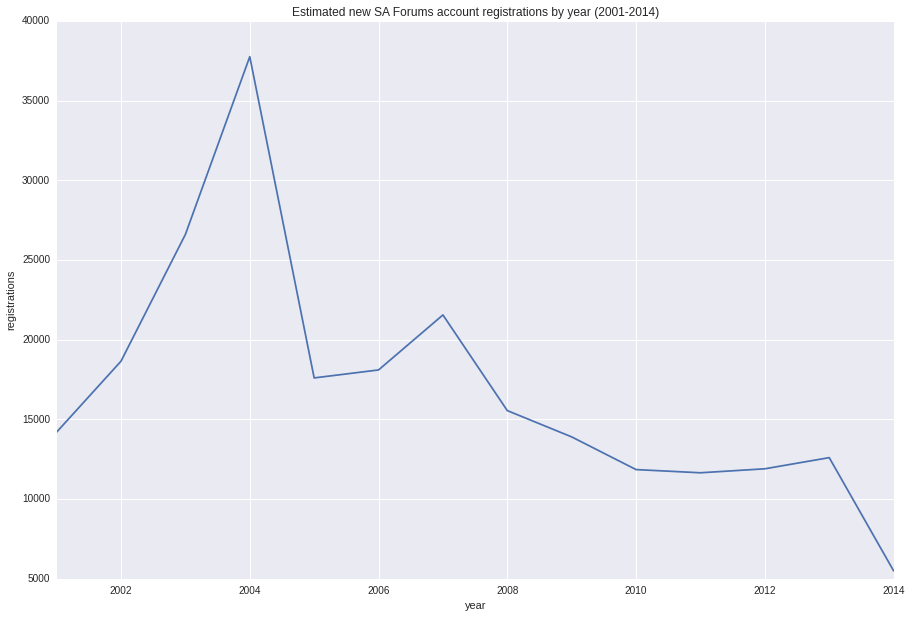

In [100]:
import seaborn as sns
ser.plot(kind='line')
plt.xlabel('year')
plt.ylabel('registrations')
plt.title('Estimated new SA Forums account registrations by year (2001-2014)')

In [101]:
ser

year
2001    14200
2002    18650
2003    26600
2004    37750
2005    17600
2006    18100
2007    21550
2008    15550
2009    13900
2010    11850
2011    11650
2012    11900
2013    12600
2014     5500
Name: uid, dtype: int64